#Import All Packages Needed

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

sns.set(rc={"figure.dpi":150, 'savefig.dpi':150})
sns.set_context('notebook')
sns.set_style("ticks")

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import (GridSearchCV,
                                     cross_val_score,
                                     KFold)

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier,
                              GradientBoostingClassifier)

from sklearn.metrics import (classification_report,
                             plot_roc_curve,
                             accuracy_score,
                             recall_score,
                             confusion_matrix)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#Helper Function

In [ ]:
def show_values(axs, orient="v", space=.02):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.4f}'.format(p.get_height())
                ax.text(_x, _y-0.01, value, ha="center",fontsize = 10)
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

#Read Application Record Data
###As our data are splitted into application and credit record: The former holds all kinds of information about applicants to a credit card, while the later contains their credit record: which is where our target information comes from.

In [ ]:
#read and display data
app = pd.read_csv('application_record.csv')
print(f'There are {app.shape[0]} records in total, each with {app.shape[1]} features')

There are 438557 records in total, each with 18 features


In [ ]:
#column type information
app.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [ ]:
#dataset infomation
app.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,4.385570e+05,438557.000000,4.385570e+05,438557.000000,438557.000000,438557.0,438557.000000,438557.000000,438557.000000,438557.000000
mean,6.022176e+06,0.427390,1.875243e+05,-15997.904649,60563.675328,1.0,0.206133,0.287771,0.108207,2.194465
std,5.716370e+05,0.724882,1.100869e+05,4185.030007,138767.799647,0.0,0.404527,0.452724,0.310642,0.897207
min,5.008804e+06,0.000000,2.610000e+04,-25201.000000,-17531.000000,1.0,0.000000,0.000000,0.000000,1.000000
25%,5.609375e+06,0.000000,1.215000e+05,-19483.000000,-3103.000000,1.0,0.000000,0.000000,0.000000,2.000000
50%,6.047745e+06,0.000000,1.607805e+05,-15630.000000,-1467.000000,1.0,0.000000,0.000000,0.000000,2.000000
75%,6.456971e+06,1.000000,2.250000e+05,-12514.000000,-371.000000,1.0,0.000000,1.000000,0.000000,3.000000
max,7.999952e+06,19.000000,6.750000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000


In [ ]:
#a random sample of 5
app.sample(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
104207,6281331,F,Y,Y,1,270000.0,Commercial associate,Higher education,Married,House / apartment,-15330,-5750,1,0,0,0,Managers,3.0
18666,5053689,M,Y,Y,1,225000.0,Working,Secondary / secondary special,Married,House / apartment,-16175,-2371,1,0,0,0,Drivers,3.0
75655,6786129,M,Y,Y,0,135000.0,Working,Secondary / secondary special,Civil marriage,Municipal apartment,-19040,-181,1,0,0,0,Drivers,2.0
235885,6006936,F,N,Y,0,157500.0,Pensioner,Secondary / secondary special,Widow,House / apartment,-22099,365243,1,0,0,0,NaN,1.0
203798,6731179,F,Y,N,0,675000.0,Working,Higher education,Married,House / apartment,-18029,-1856,1,1,1,0,Managers,2.0


there are 134203 missing values in OCCUPATION_TYPE column
there are 0 duplicated records


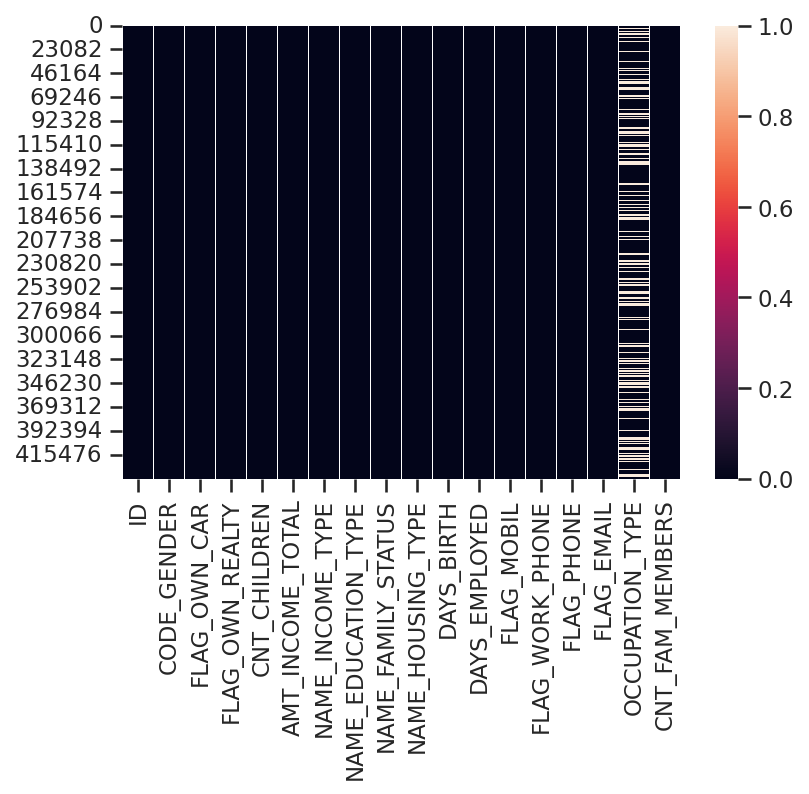

In [ ]:
#check for na and dubplicated value
sns.heatmap(app.isnull())
#there are missing value only in occupation type column and they seem randomly distributed
print(f"there are {app.isnull().sum()['OCCUPATION_TYPE']} missing values in OCCUPATION_TYPE column")
print(f'there are {app.duplicated().sum()} duplicated records')

###As there are missing values only in the occupation type column, which is a categorical variable, we decided not to remove the na values but to mark them as an addtional occupation level, namely 'Unknown'.

In [ ]:
#Transform na values to category level
print(f"NA Level takes up {str(app.isnull().sum()['OCCUPATION_TYPE']/app.shape[0])[2:4]} percent of total observations")
app['OCCUPATION_TYPE'] = app['OCCUPATION_TYPE'].apply(lambda x: 'N/A' if pd.isnull(x) else x)

NA Level takes up 30 percent of total observations


###Encode and check all columns

In [ ]:
#Male coded by 1, Female Coded by 0
app['CODE_GENDER'] = app['CODE_GENDER'].apply(lambda x: 1 if x == 'M' else 0)

#Own car coded by 1, Without Car Coded by 0
app['FLAG_OWN_CAR'] = app['FLAG_OWN_CAR'].apply(lambda x: 1 if x == 'Y' else 0)

#Own realty coded by 1, Without realty Coded by 0
app['FLAG_OWN_REALTY'] = app['FLAG_OWN_REALTY'].apply(lambda x: 1 if x == 'Y' else 0)

#All value in FLAG_MOBIL equals 1, thus dropping the column
app.drop(columns = ['FLAG_MOBIL'],inplace = True)

#Rename levels for columns with mutiple categories
app = app.replace({'NAME_INCOME_TYPE' : {'Working':'Working',
                                  'Commercial associate':'Commercial_associate',
                                  'Pensioner':'Pensioner',
                                  'State servant':'State servant',
                                  'Student':'Student'}})

app = app.replace({'NAME_EDUCATION_TYPE' : {'Higher education':'Higher',
                                      'Secondary / secondary special':'Secondary',
                                      'Incomplete higher':'Incomplete',
                                      'Lower secondary':'Lower_secondary',
                                      'Academic degree':'Academic'}})

app = app.replace({'NAME_FAMILY_STATUS' : {'Civil marriage':'Civil',
                                      'Single / not married':'Single',}})

app = app.replace({'NAME_HOUSING_TYPE' : {'Rented apartment':'Rented_apartment',
                                           'House / apartment':'House_apartment',
                                           'Municipal apartment':'Municipal_apartment',
                                           'With parents':'With_parents',
                                           'Co-op apartment':'Coop_apartment',
                                           'Office apartment':'Office_apartment'}})

app = app.replace({'OCCUPATION_TYPE' : {'N/A':'NoRecord',
                                        'Security staff':'Security',
                                        'Sales staff':'Sales',
                                        'Core staff':'Core',
                                        'High skill tech staff':'High Tech',
                                        'Cleaning staff':'Cleaning',
                                        'Private service staff':'Private_service',
                                        'Cooking staff':'Cooking',
                                        'Low-skill Laborers':'Lowskill_Laborers',
                                        'Medicine staff':'Medicine',
                                        'Waiters/barmen staff':'Waiters',
                                        'HR staff':'HR',
                                        'Realty agents':'Realty',
                                        'IT staff':'IT'}})

#Transform DAYS_BIRTH to ages
app['AGE'] = app['DAYS_BIRTH'].apply(lambda x: -x//365)
app.drop(columns = ['DAYS_BIRTH'], inplace = True)


#app[app['DAYS_EMPLOYED'] > 350000].shape[0]
#app[app['DAYS_EMPLOYED'] > 350000]['OCCUPATION_TYPE'].value_counts()
#There are a lot 75329 values with '365243' in DAYS_EMPLOYED, which might be an indicator for people being unemployed and are all marked as no record in OCCUPATION_TYPE.
#Record with '365243' as their DAYS_EMPLOYED will be changed to 0, and another dummy variable will be added to indicte people's employment status
#Employed coded by 1, Unemployed coded by 0
app['DAYS_EMPLOYED'] = app['DAYS_EMPLOYED'].apply(lambda x: 0 if x == 365243 else x)
app['YEARS_EMPLOYED'] = app['DAYS_EMPLOYED'].apply(lambda x: -x//365)
app['Employed'] = app['DAYS_EMPLOYED'].apply(lambda x: 0 if x == 0 else 1)
app.drop(columns = ['DAYS_EMPLOYED'], inplace = True)

#application record after cleaning
app.sample(5)
#app.describe()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE,YEARS_EMPLOYED,Employed
170018,5797378,0,0,1,0,180000.0,Pensioner,Secondary,Single,House_apartment,0,0,0,NoRecord,1.0,58,0,0
416513,6806121,0,0,1,0,252000.0,State servant,Higher,Married,House_apartment,0,0,1,Medicine,2.0,37,7,1
401747,6727962,1,1,1,0,135000.0,Pensioner,Higher,Married,House_apartment,0,0,0,NoRecord,2.0,52,0,0
325190,6291994,1,1,1,0,126000.0,State servant,Secondary,Married,House_apartment,0,0,0,Drivers,2.0,49,0,1
433310,7702732,1,1,1,0,157500.0,Working,Secondary,Single,House_apartment,0,0,0,High Tech,1.0,23,0,1


#Read Application Credit Data


In [ ]:
credit = pd.read_csv('credit_record.csv')
print(f'There are {credit.shape[0]} records in total, each with {credit.shape[1]} features')

There are 1048575 records in total, each with 3 features


In [ ]:
#column type information
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB


In [ ]:
#a random sample of 5
credit.sample(5)

,ID,MONTHS_BALANCE,STATUS
900560,5121970,-1,0
1039863,5149762,-16,X
370561,5041968,-5,C
474103,5059775,-39,X
560740,5067256,-33,X


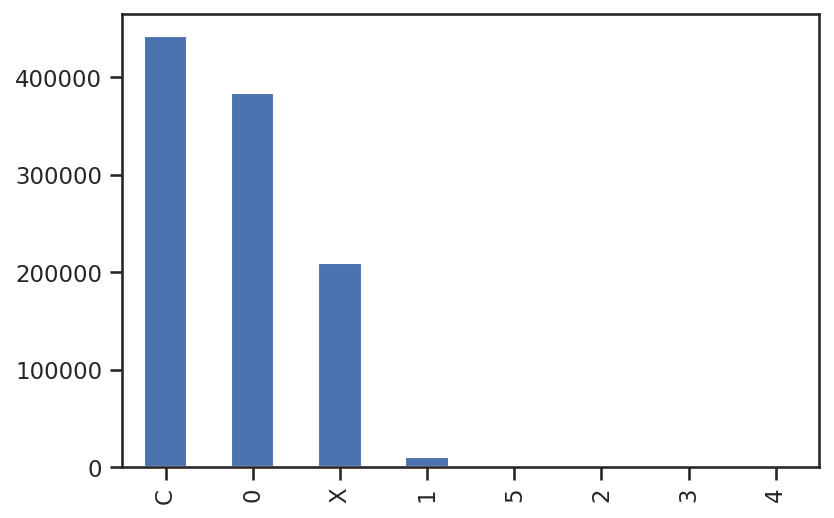

In [ ]:
credit['STATUS'].value_counts().plot(kind='bar')

there are 0 missing values
there are 0 duplicated records


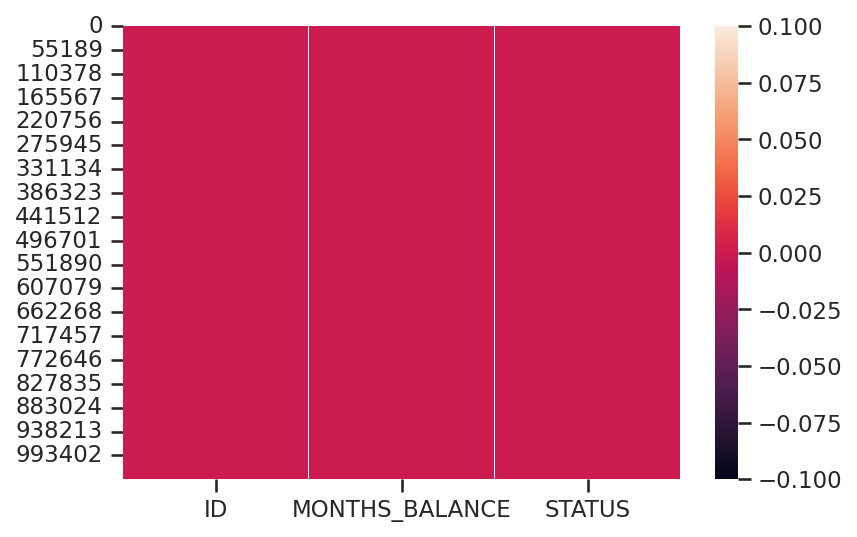

In [ ]:
#check for na and dubplicated value
sns.heatmap(credit.isnull())
#there are missing value only in occupation type column and they seem randomly distributed
print(f"there are {credit.isnull().sum().sum()} missing values")
print(f'there are {credit.duplicated().sum()} duplicated records')

In [ ]:
#Create a new dataframe for pivoted credit record
credit_final = pd.DataFrame({'ID':credit.ID.unique()}, index = range(credit.ID.nunique()))

for index,ID in enumerate(credit_final.ID):
  #Extrct account opening time
  first_record_time = credit[credit['ID'] == ID]['MONTHS_BALANCE'].min()
  #Extrct numbers of credit records
  record_counts = len(credit[credit['ID'] == ID]['MONTHS_BALANCE'])
  #Extrct last record time
  last_record_time = credit[credit['ID'] == ID]['MONTHS_BALANCE'].max()

  #extract different status of record counts: how many times past due for a month, two month, and etc
  credit_dictionary = defaultdict(int)
  credit_records = credit[credit['ID'] == ID]['STATUS'].value_counts()
  for i in credit_records.index:
    credit_dictionary[i] = credit_records[i]
  X_count = credit_dictionary['X']
  zero_count = credit_dictionary['0']
  C_count =  credit_dictionary['C']
  one_count = credit_dictionary['1']
  two_count = credit_dictionary['2']
  three_count = credit_dictionary['3']
  four_count = credit_dictionary['4']
  five_count = credit_dictionary['5']

  credit_final.loc[index,['first_record_time','record_counts','last_record_time','X_count','zero_count','C_count','one_count','two_count','three_count','four_count','five_count']] = first_record_time, record_counts, last_record_time, X_count, zero_count, C_count, one_count, two_count, three_count, four_count, five_count
  if index % 1000 == 0:
    print(f'currently processing {index}th/{len(credit_final.ID)} records')

currently processing 0th/45985 records
currently processing 1000th/45985 records
currently processing 2000th/45985 records
currently processing 3000th/45985 records
currently processing 4000th/45985 records
currently processing 5000th/45985 records
currently processing 6000th/45985 records
currently processing 7000th/45985 records
currently processing 8000th/45985 records
currently processing 9000th/45985 records
currently processing 10000th/45985 records
currently processing 11000th/45985 records
currently processing 12000th/45985 records
currently processing 13000th/45985 records
currently processing 14000th/45985 records
currently processing 15000th/45985 records
currently processing 16000th/45985 records
currently processing 17000th/45985 records
currently processing 18000th/45985 records
currently processing 19000th/45985 records
currently processing 20000th/45985 records
currently processing 21000th/45985 records
currently processing 22000th/45985 records
currently processing 230

In [ ]:
#Transform data to correct type
credit_final['first_record_time'] = credit_final['first_record_time'].astype('int')
credit_final['record_counts'] = credit_final['record_counts'].astype('int')
credit_final['last_record_time'] = credit_final['last_record_time'].astype('int')
credit_final['zero_count'] = credit_final['zero_count'].astype('int')
credit_final['X_count'] = credit_final['X_count'].astype('int')
credit_final['C_count'] = credit_final['C_count'].astype('int')
credit_final['one_count'] = credit_final['one_count'].astype('int')
credit_final['two_count'] = credit_final['two_count'].astype('int')
credit_final['three_count'] = credit_final['three_count'].astype('int')
credit_final['four_count'] = credit_final['four_count'].astype('int')
credit_final['five_count'] = credit_final['five_count'].astype('int')
#credit record after cleaning
credit_final.sample(5)

,ID,first_record_time,record_counts,last_record_time,X_count,zero_count,C_count,one_count,two_count,three_count,four_count,five_count
45362,5149509,-29,19,-11,0,6,13,0,0,0,0,0
16252,5045654,-6,7,0,0,6,0,1,0,0,0,0
14692,5038854,-46,21,-26,0,10,10,1,0,0,0,0
31190,5096466,-31,18,-14,0,4,14,0,0,0,0,0
6894,5016906,-26,27,0,0,0,27,0,0,0,0,0


#Merging application and credit datasets

In [ ]:
print(f'There are {app.ID.nunique()} unique values in application record, {credit.ID.nunique()} in credit record')
final_data = app.merge(credit_final,on = 'ID',how = 'inner')
print(f'There are {final_data.shape[0]} records after joining, each with {final_data.shape[1]} features')
#Construct Target Column
final_data['Total_Default_Count'] = final_data['two_count'] + final_data['three_count'] + final_data['four_count'] + final_data['five_count']
#people with default more than 2 month will be counted as default, which matches US average credit default rate
final_data['Default'] = final_data['Total_Default_Count'].apply(lambda x: 1 if x > 0 else 0)
final_data['Default'].value_counts()
print(f"There are {str(final_data['Default'].value_counts()[1]/final_data.shape[0])[:6]} defaults in the final data" )
final_data.sample(5)

There are 438510 unique values in application record, 45985 in credit record
There are 36457 records after joining, each with 29 features
There are 0.0168 defaults in the final data


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,...,X_count,zero_count,C_count,one_count,two_count,three_count,four_count,five_count,Total_Default_Count,Default
1935,5021265,0,0,0,0,135000.0,Working,Incomplete,Single,Rented_apartment,...,0,7,26,1,0,0,0,0,0,0
27228,5113833,0,0,1,0,360000.0,Commercial_associate,Higher,Married,House_apartment,...,0,9,1,0,0,0,0,0,0,0
17318,5067700,1,1,1,0,450000.0,Working,Higher,Married,House_apartment,...,20,26,0,4,0,0,0,0,0,0
1326,5010467,0,1,1,1,157500.0,Working,Secondary,Married,House_apartment,...,0,8,6,0,0,0,0,0,0,0
27045,5113542,0,0,0,2,193500.0,Commercial_associate,Lower_secondary,Civil,House_apartment,...,1,5,0,0,0,0,0,0,0,0


#Explornatory Data Analysis

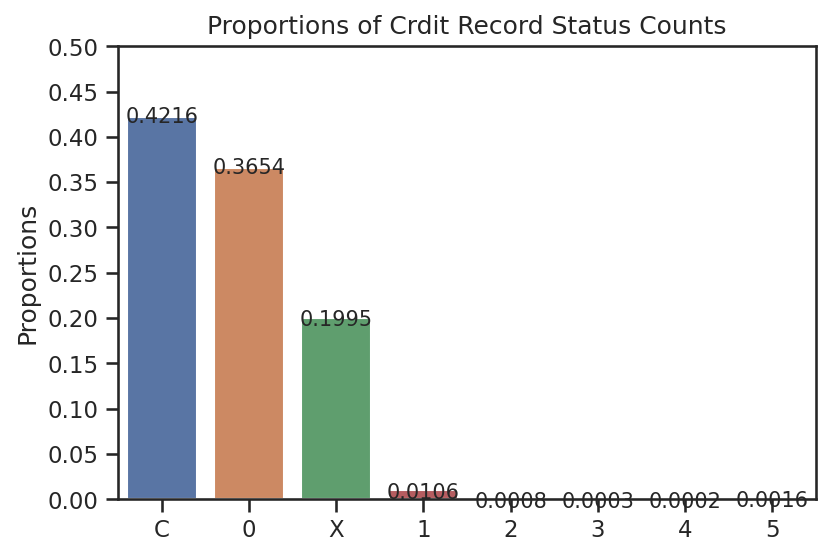

In [ ]:
data_for_class = credit['STATUS'].value_counts(normalize = True).reset_index()
ax = sns.barplot(data = data_for_class, x = 'index', y = 'STATUS',order = ['C', '0', 'X', '1','2', '3', '4', '5'])
ax.set_yticks([0.00,0.05,0.10,0.15,0.20,0.25,0.30,0.35,0.40,0.45,0.50])
ax.set_xlabel(None)
ax.set_ylabel('Proportions')
ax.set_title('Proportions of Crdit Record Status Counts')
show_values(ax)

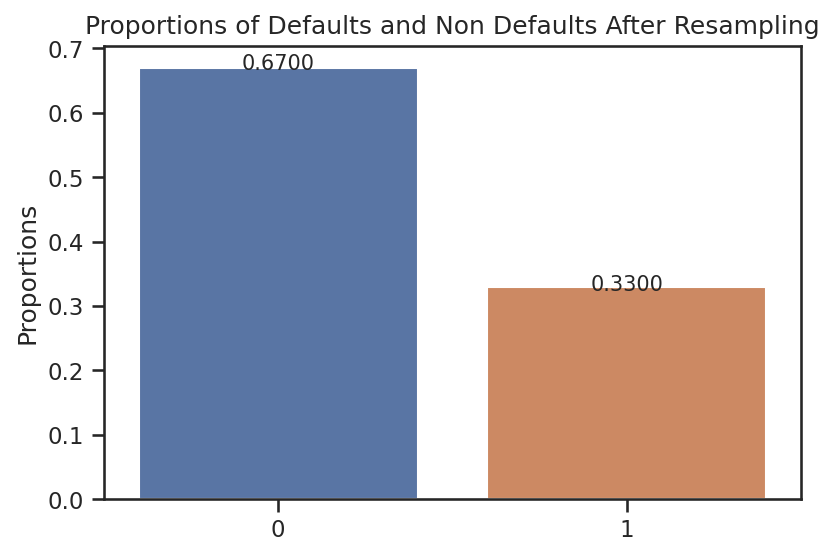

In [ ]:
data_for_class1 = final_data.Default.value_counts(normalize = True).reset_index()
data_for_class1.loc[0:1,'Default'] = 0.67
data_for_class1.loc[1:2,'Default'] = 0.33
ax = sns.barplot(x = 'index', y = 'Default', data = data_for_class1)
ax.set_ylabel('Proportions')
ax.set_title('Proportions of Defaults and Non Defaults After Resampling')
ax.set_xlabel(None)
show_values(ax)

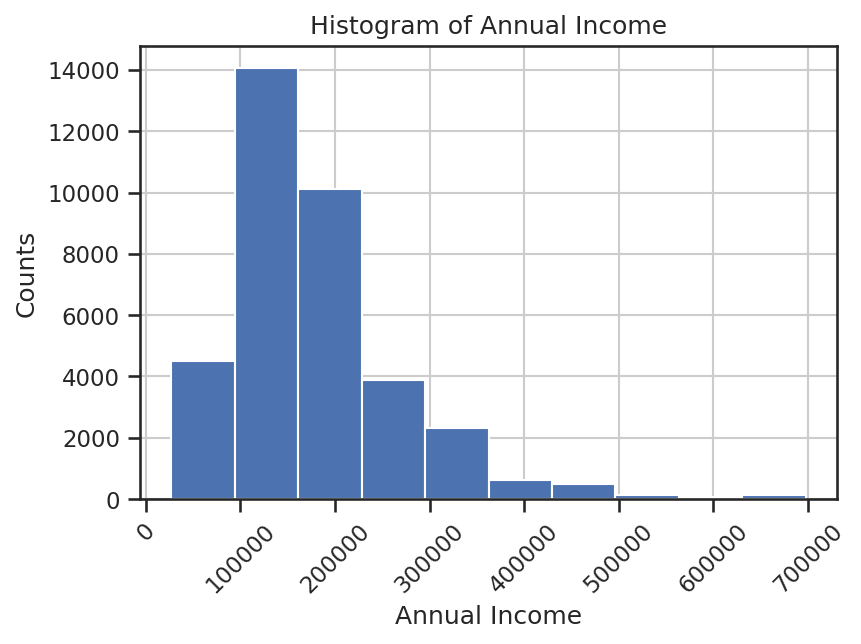

In [ ]:
final_data[final_data.AMT_INCOME_TOTAL <= 700000]['AMT_INCOME_TOTAL'].hist()
plt.title('Histogram of Annual Income')
plt.xlabel('Annual Income')
plt.xticks(rotation = 45)
plt.ylabel('Counts')
plt.show()

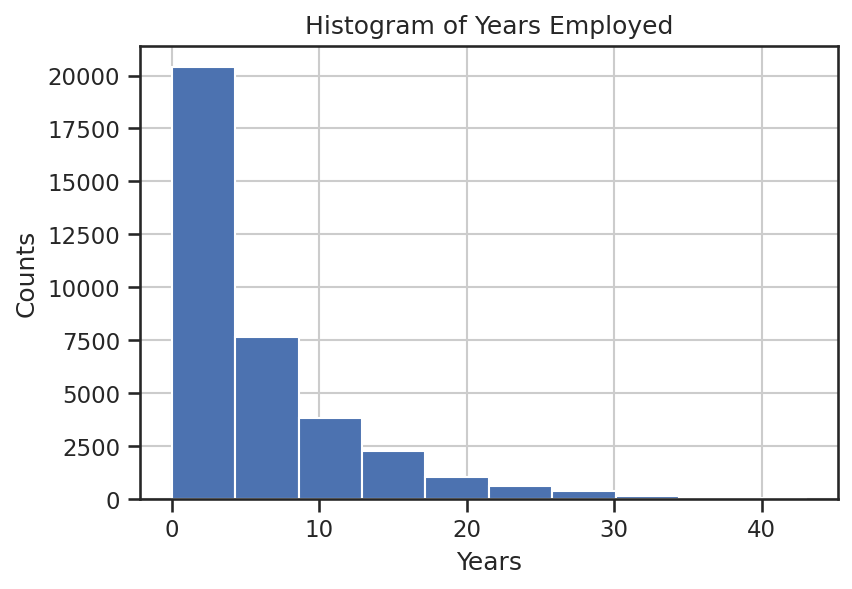

In [ ]:
final_data['YEARS_EMPLOYED'].hist()
plt.title('Histogram of Years Employed')
plt.xlabel('Years')
plt.ylabel('Counts')
plt.show()

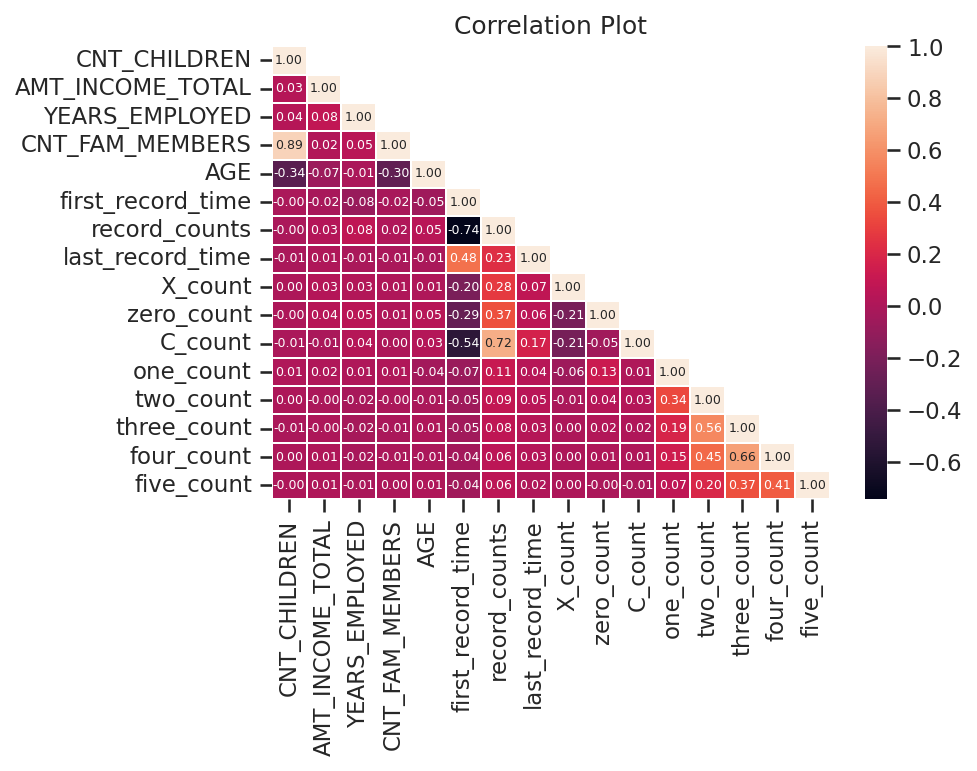

In [ ]:
continuous = ['CNT_CHILDREN','AMT_INCOME_TOTAL','YEARS_EMPLOYED',
              'CNT_FAM_MEMBERS','AGE','first_record_time','record_counts',
              'last_record_time','X_count', 'zero_count', 'C_count',
              'one_count', 'two_count', 'three_count', 'four_count', 'five_count']

mask = np.zeros(shape = (len(continuous),len(continuous)))
for i in range(len(continuous)):
  for j in range(len(continuous)):
    if i < j:
      mask[i][j] = True
    else:
      mask[i][j] = False
sns.heatmap(final_data[continuous].corr(),annot = True,fmt=".2f",linewidth=.5, mask = mask,annot_kws={"size": 6})
plt.title('Correlation Plot')
plt.show()

Text(0.5, 1.0, 'Average Defaults Rate and Age of Different Years Employed Group')

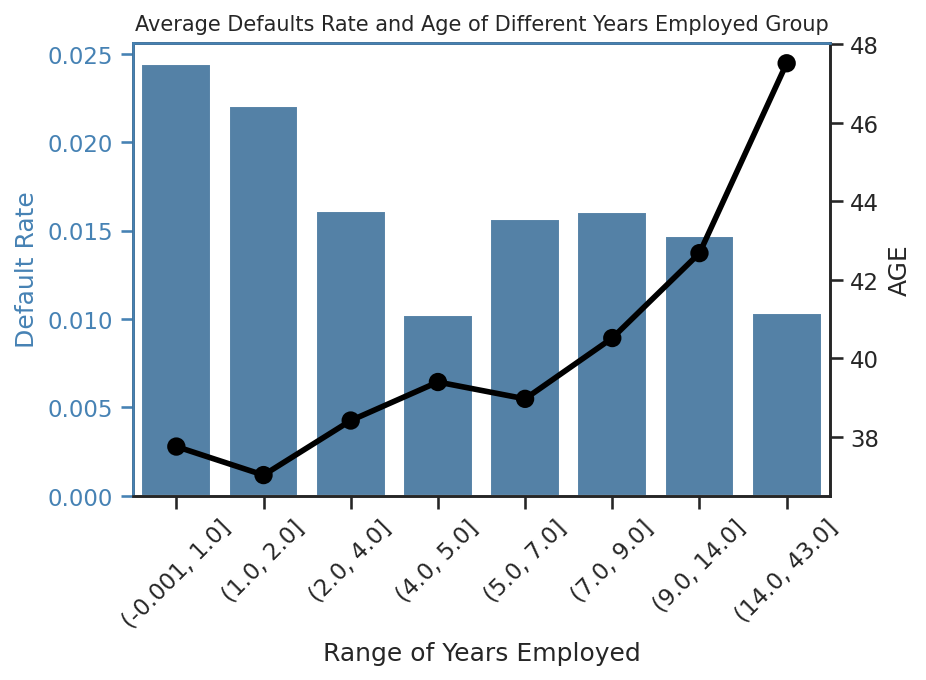

In [ ]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
final_data['EMPLOY_CATEGORY'] =  pd.qcut(final_data['YEARS_EMPLOYED'], 10,duplicates='drop')
plot_data = final_data[final_data['YEARS_EMPLOYED'] != 0]
plot = plot_data.groupby('EMPLOY_CATEGORY')['Default','AGE'].mean().reset_index()
sns.barplot(x = 'EMPLOY_CATEGORY', y = 'Default', data = plot, ax = ax, color = 'steelblue')
sns.pointplot(x = 'EMPLOY_CATEGORY', y = 'AGE', data = plot, ax = ax2, color = 'black')
ax.set_xticklabels(plot['EMPLOY_CATEGORY'], rotation = 45)
ax2.spines['left'].set_color('steelblue')
ax2.spines['top'].set_color('steelblue')
ax.yaxis.label.set_color('steelblue')
ax.tick_params(axis='y', colors='steelblue')
ax.set_xlabel('Range of Years Employed')
ax.set_ylabel('Default Rate')
ax.set_title('Average Defaults Rate and Age of Different Years Employed Group', fontsize = 10)

Text(0.5, 1.0, 'Average Defaults Rate and Counts of Different Occupations')

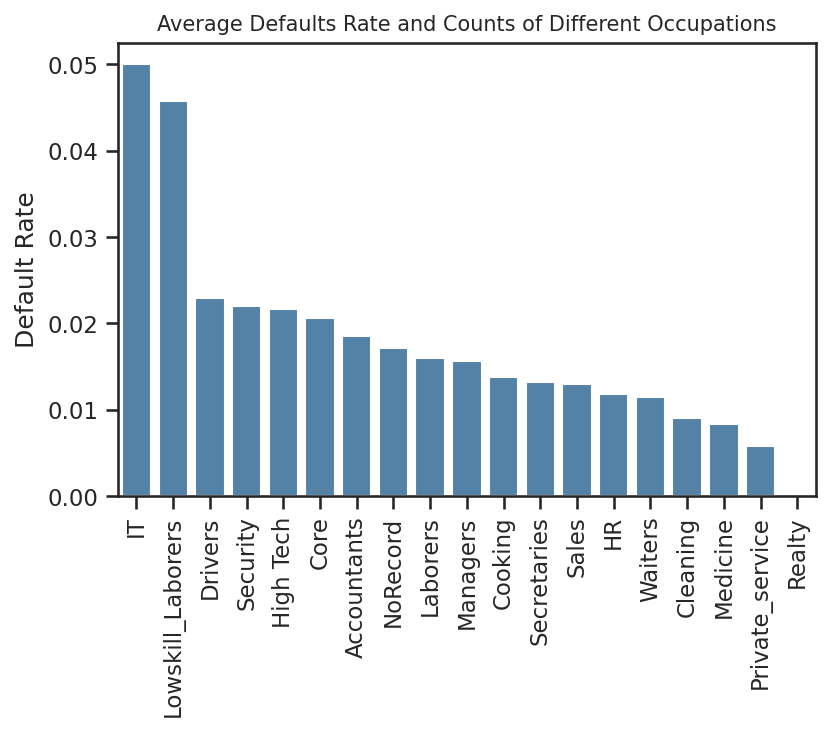

In [ ]:
fig, ax = plt.subplots()
#ax2 = ax.twinx()
plot = final_data.groupby('OCCUPATION_TYPE')['Default'].agg(['mean','count']).reset_index().sort_values(by = 'mean', ascending = False)
sns.barplot(x = 'OCCUPATION_TYPE', y = 'mean', data = plot, color = 'steelblue',ax = ax)
#sns.pointplot(x = 'OCCUPATION_TYPE', y = 'count', data = plot, color = 'black',ax = ax2, scale = 0.6)
ax.set_xticklabels(plot['OCCUPATION_TYPE'], rotation = 90)
#ax2.spines['left'].set_color('steelblue')
#ax2.spines['top'].set_color('steelblue')
#ax.yaxis.label.set_color('steelblue')
#ax.tick_params(axis='y', colors='steelblue')
ax.set_xlabel('Range of Years Employed')
ax.set_ylabel('Default Rate')
ax.set_xlabel(None)
ax.set_title('Average Defaults Rate and Counts of Different Occupations', fontsize = 10)

Text(0.5, 1.0, 'Compared Average Default Rate and Number of Credit Record')

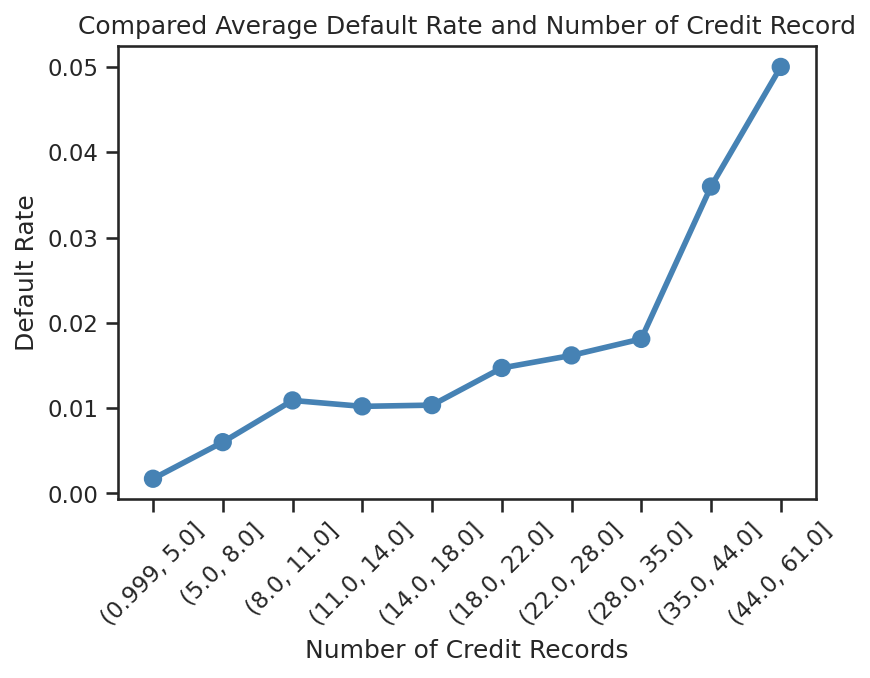

In [ ]:
fig, ax = plt.subplots()
final_data['RECORD_CATEGORY'] =  pd.qcut(final_data['record_counts'], 10,duplicates='drop')
plot = final_data.groupby('RECORD_CATEGORY')['Default'].agg(['mean','count']).reset_index()
sns.pointplot(x = 'RECORD_CATEGORY', y = 'mean', data = plot, color = 'steelblue',ax = ax)
ax.set_xticklabels(plot['RECORD_CATEGORY'], rotation = 45)
ax.set_xlabel('Number of Credit Records')
ax.set_ylabel('Default Rate')
ax.set_title('Compared Average Default Rate and Number of Credit Record')

[Text(0, 0, 'Office_apartment'),
 Text(0, 0, 'Municipal_apartment'),
 Text(0, 0, 'Coop_apartment'),
 Text(0, 0, 'House_apartment'),
 Text(0, 0, 'With_parents'),
 Text(0, 0, 'Rented_apartment')]

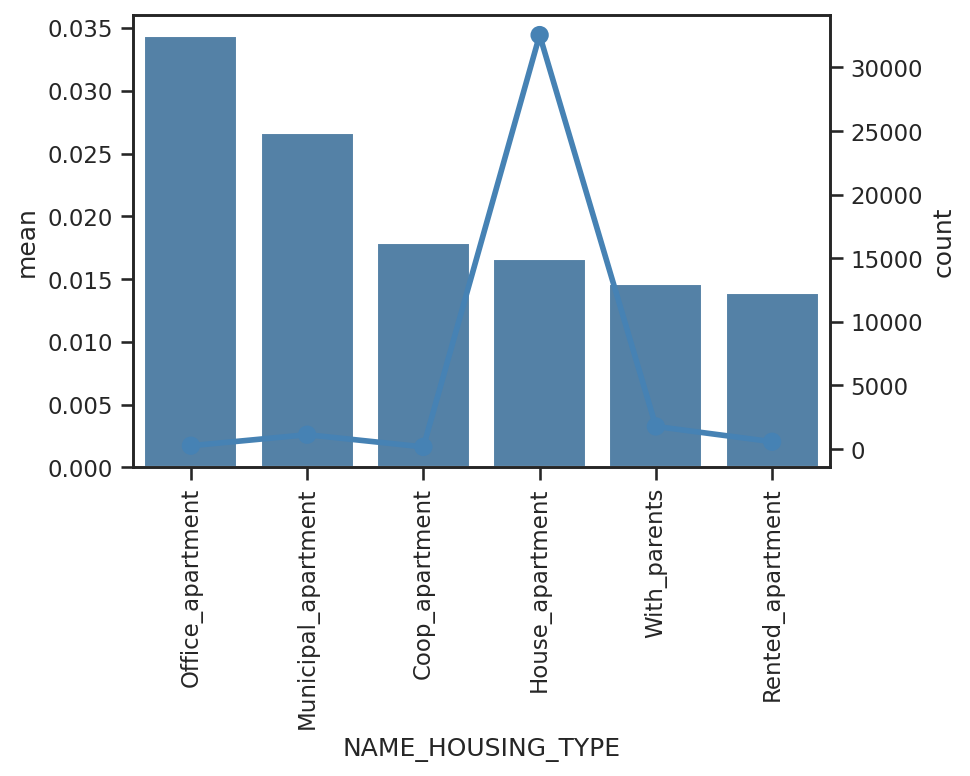

In [ ]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
plot = final_data.groupby('NAME_HOUSING_TYPE')['Default'].agg(['mean','count']).reset_index().sort_values(by = 'mean', ascending = False)
sns.barplot(x = 'NAME_HOUSING_TYPE', y = 'mean', data = plot, color = 'steelblue',ax = ax)
sns.pointplot(x = 'NAME_HOUSING_TYPE', y = 'count', data = plot, color = 'steelblue',ax = ax2)
ax.set_xticklabels(plot['NAME_HOUSING_TYPE'], rotation = 90)

#Prepare datasets for modeling

In [ ]:
#Transform categorical variable into dummies
data_with_dummies = pd.get_dummies(final_data,columns = ['NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE'],drop_first = True)
print(f'There are {len(data_with_dummies.columns)} features in total')
#data_with_dummies.info()

There are 61 features in total


In [ ]:
predictors = ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN',
       'AMT_INCOME_TOTAL', 'YEARS_EMPLOYED', 'FLAG_WORK_PHONE', 'FLAG_PHONE',
       'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'AGE', 'Employed', 'first_record_time',
       'record_counts', 'last_record_time', 'NAME_INCOME_TYPE_Pensioner',
       'NAME_INCOME_TYPE_State servant', 'NAME_INCOME_TYPE_Student',
       'NAME_INCOME_TYPE_Working', 'NAME_EDUCATION_TYPE_Higher',
       'NAME_EDUCATION_TYPE_Incomplete', 'NAME_EDUCATION_TYPE_Lower_secondary',
       'NAME_EDUCATION_TYPE_Secondary', 'NAME_FAMILY_STATUS_Married',
       'NAME_FAMILY_STATUS_Separated', 'NAME_FAMILY_STATUS_Single',
       'NAME_FAMILY_STATUS_Widow', 'NAME_HOUSING_TYPE_House_apartment',
       'NAME_HOUSING_TYPE_Municipal_apartment',
       'NAME_HOUSING_TYPE_Office_apartment',
       'NAME_HOUSING_TYPE_Rented_apartment', 'NAME_HOUSING_TYPE_With_parents',
       'OCCUPATION_TYPE_Cleaning', 'OCCUPATION_TYPE_Cooking',
       'OCCUPATION_TYPE_Core', 'OCCUPATION_TYPE_Drivers', 'OCCUPATION_TYPE_HR',
       'OCCUPATION_TYPE_High Tech', 'OCCUPATION_TYPE_IT',
       'OCCUPATION_TYPE_Laborers', 'OCCUPATION_TYPE_Lowskill_Laborers',
       'OCCUPATION_TYPE_Managers', 'OCCUPATION_TYPE_Medicine',
       'OCCUPATION_TYPE_NoRecord', 'OCCUPATION_TYPE_Private_service',
       'OCCUPATION_TYPE_Realty', 'OCCUPATION_TYPE_Sales',
       'OCCUPATION_TYPE_Secretaries', 'OCCUPATION_TYPE_Security',
       'OCCUPATION_TYPE_Waiters'
       ]
target = ['Default']

In [ ]:
#Train and validation set split
X_train, X_test, y_train, y_test = train_test_split(data_with_dummies[predictors],
                                                    data_with_dummies[target],
                                                    test_size=0.2,
                                                    shuffle = True,
                                                    stratify = data_with_dummies[target])
print(X_train.shape,X_test.shape)

(29165, 50) (7292, 50)


In [ ]:
#standardize training data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

scaler = StandardScaler()
X = scaler.fit_transform(data_with_dummies[predictors])
y = data_with_dummies[target]

#modeling

Logistic Regression

In [ ]:
pipeline_logistic = make_pipeline(SMOTE(sampling_strategy = 0.33),
                                  LogisticRegression(random_state = 42))

params = {'logisticregression__C':[0.9,0.5,0.1,0.01,0.001,0.0001,0.00001],
          'logisticregression__penalty':['l1','l2','elasticnet','none'],
          'logisticregression__l1_ratio':[0.5],
          'logisticregression__solver':['saga']}

result_logistic = GridSearchCV(pipeline_logistic, param_grid=params, cv=5, scoring='f1',verbose = 3)
result_logistic.fit(X_train, y_train)

Fitting 5 folds for each of 28 candidates, totalling 140 fits
[CV 1/5] END logisticregression__C=0.9, logisticregression__l1_ratio=0.5, logisticregression__penalty=l1, logisticregression__solver=saga;, score=0.099 total time=   3.8s
[CV 2/5] END logisticregression__C=0.9, logisticregression__l1_ratio=0.5, logisticregression__penalty=l1, logisticregression__solver=saga;, score=0.114 total time=   3.7s
[CV 3/5] END logisticregression__C=0.9, logisticregression__l1_ratio=0.5, logisticregression__penalty=l1, logisticregression__solver=saga;, score=0.095 total time=   3.6s
[CV 4/5] END logisticregression__C=0.9, logisticregression__l1_ratio=0.5, logisticregression__penalty=l1, logisticregression__solver=saga;, score=0.118 total time=   3.9s
[CV 5/5] END logisticregression__C=0.9, logisticregression__l1_ratio=0.5, logisticregression__penalty=l1, logisticregression__solver=saga;, score=0.143 total time=   3.9s
[CV 1/5] END logisticregression__C=0.9, logisticregression__l1_ratio=0.5, logisticr

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote', SMOTE(sampling_strategy=0.33)),
                                       ('logisticregression',
                                        LogisticRegression(random_state=42))]),
             param_grid={'logisticregression__C': [0.9, 0.5, 0.1, 0.01, 0.001,
                                                   0.0001, 1e-05],
                         'logisticregression__l1_ratio': [0.5],
                         'logisticregression__penalty': ['l1', 'l2',
                                                         'elasticnet', 'none'],
                         'logisticregression__solver': ['saga']},
             scoring='f1', verbose=3)

              precision    recall  f1-score   support

           0     0.9862    0.9347    0.9598      7169
           1     0.0584    0.2358    0.0935       123

    accuracy                         0.9229      7292
   macro avg     0.5223    0.5852    0.5267      7292
weighted avg     0.9705    0.9229    0.9451      7292



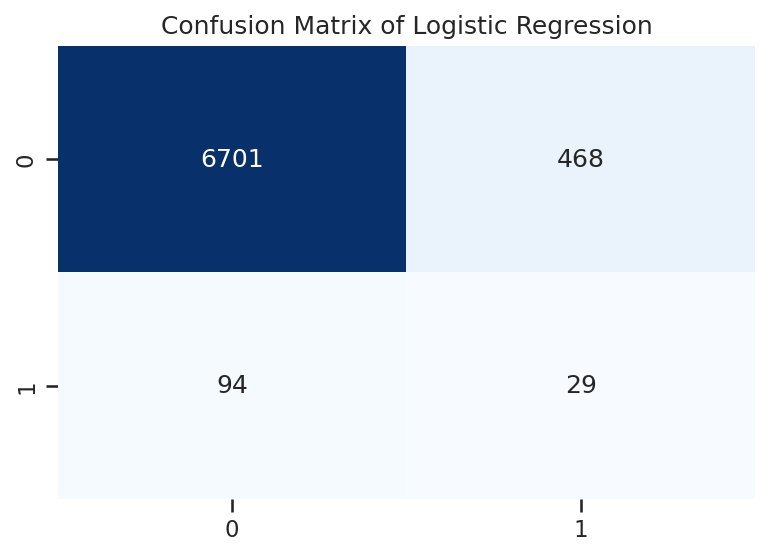

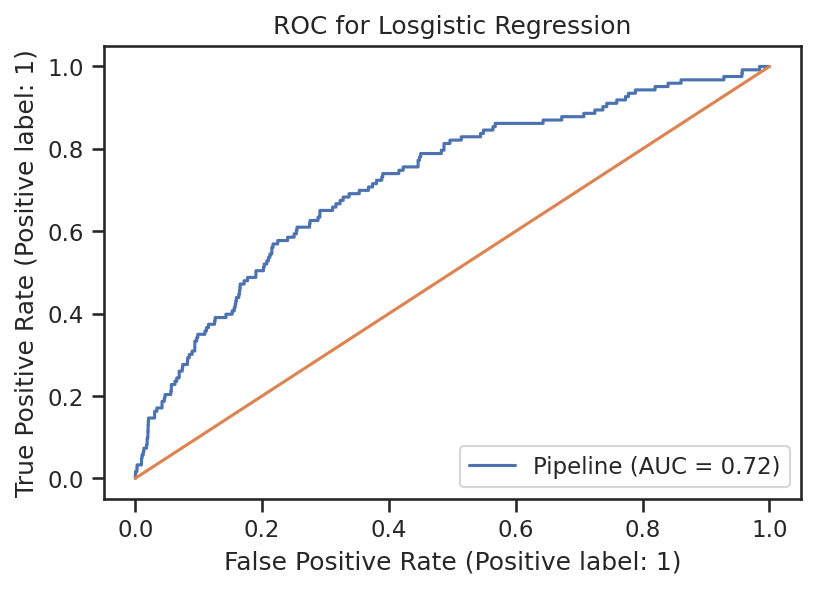

In [ ]:
params = {k[len('LogisticRegression__'):]:v for k,v in result_logistic.best_params_.items()}
Logistic = make_pipeline(SMOTE(sampling_strategy = 0.33,random_state = 42),
                     LogisticRegression(**params))
Logistic.fit(X_train,y_train)
preds = Logistic.predict(X_test)
print(classification_report(y_test,preds, digits = 4))

cm = confusion_matrix(y_test,preds)
sns.heatmap(cm, annot = True, fmt='d', cbar=False, cmap='Blues').set(title = "Confusion Matrix of Logistic Regression")

plot_roc_curve(Logistic,X_test,y_test)
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100))
plt.title('ROC for Losgistic Regression')
plt.show()

Text(0.5, 1.0, 'Cross Validation F1 Score with Different Parameters')

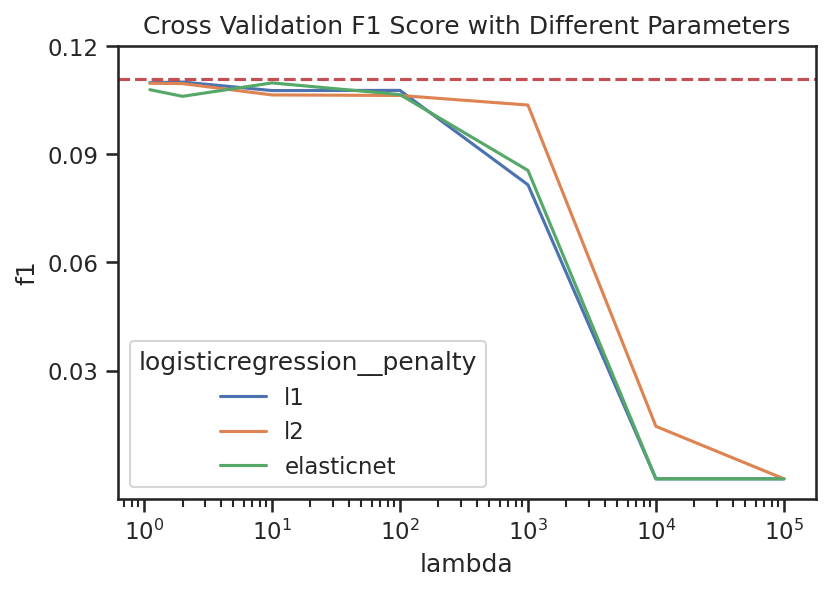

In [ ]:
data = pd.DataFrame(result_logistic.cv_results_['params'])
data['lambda'] = 1/data['logisticregression__C']
data['f1'] = result_logistic.cv_results_['mean_test_score']
sns.lineplot(x = 'lambda', y = 'f1', hue = 'logisticregression__penalty', data = data[data['logisticregression__penalty'] != 'none'])
plt.axhline(y=0.1107, color='r', linestyle='--')
plt.xscale('log')
plt.yticks([0.03,0.06,0.09,0.12])
plt.title('Cross Validation F1 Score with Different Parameters')

Text(0, 0.5, '')

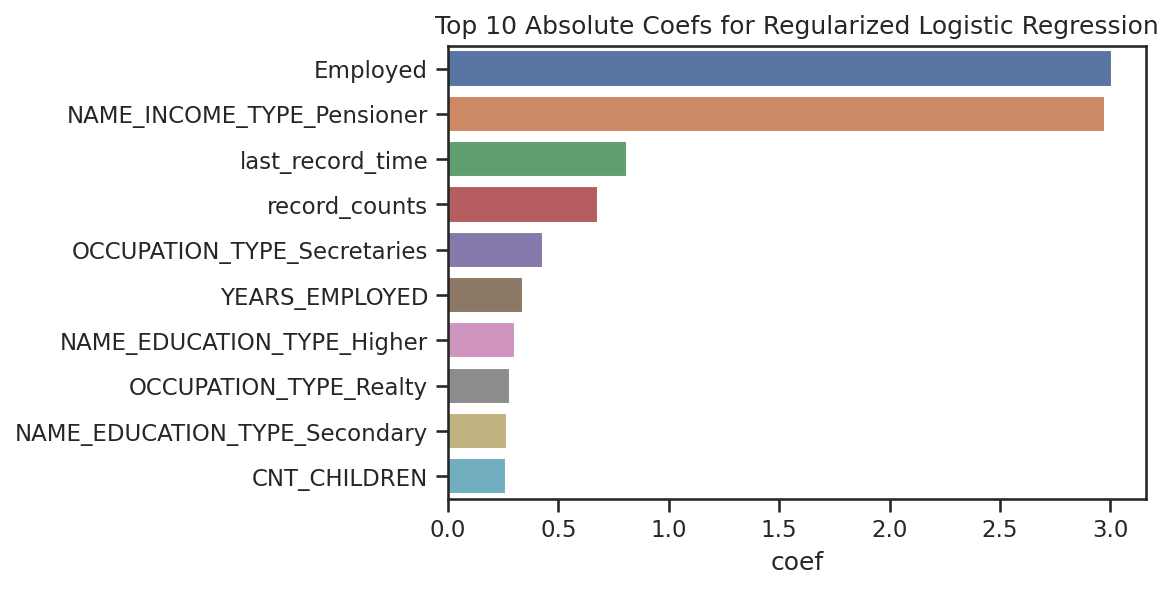

In [ ]:
data = pd.DataFrame({'predictors':predictors,'coef':np.abs(Logistic[-1].coef_[0])}).sort_values(by = 'coef', ascending = False).iloc[:10]
sns.barplot(y = 'predictors', x = 'coef', data = data)
plt.title('Top 10 Absolute Coefs for Regularized Logistic Regression')
plt.ylabel(None)

K-Nearest Neighbor

In [ ]:
pipeline_KNN = make_pipeline(SMOTE(sampling_strategy = 0.33),
                                   KNeighborsClassifier())

params = {'kneighborsclassifier__n_neighbors':[3,5,7,9,11,13,15,19,25],
          'kneighborsclassifier__metric':['cosine','manhattan','euclidean']}

result_KNN = GridSearchCV(pipeline_KNN, param_grid=params, cv=5, scoring='f1',verbose = 3)
result_KNN.fit(X_train, y_train)
params = {k[len('kneighborsclassifier__'):]:v for k,v in result_KNN.best_params_.items()}

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 1/5] END kneighborsclassifier__metric=cosine, kneighborsclassifier__n_neighbors=3;, score=0.261 total time=   3.2s
[CV 2/5] END kneighborsclassifier__metric=cosine, kneighborsclassifier__n_neighbors=3;, score=0.205 total time=   3.0s
[CV 3/5] END kneighborsclassifier__metric=cosine, kneighborsclassifier__n_neighbors=3;, score=0.213 total time=   3.3s
[CV 4/5] END kneighborsclassifier__metric=cosine, kneighborsclassifier__n_neighbors=3;, score=0.228 total time=   5.0s
[CV 5/5] END kneighborsclassifier__metric=cosine, kneighborsclassifier__n_neighbors=3;, score=0.184 total time=   2.8s
[CV 1/5] END kneighborsclassifier__metric=cosine, kneighborsclassifier__n_neighbors=5;, score=0.214 total time=   3.9s
[CV 2/5] END kneighborsclassifier__metric=cosine, kneighborsclassifier__n_neighbors=5;, score=0.186 total time=   3.9s
[CV 3/5] END kneighborsclassifier__metric=cosine, kneighborsclassifier__n_neighbors=5;, score=0.164 total

              precision    recall  f1-score   support

           0     0.9895    0.9459    0.9672      7169
           1     0.1162    0.4146    0.1815       123

    accuracy                         0.9369      7292
   macro avg     0.5528    0.6803    0.5743      7292
weighted avg     0.9748    0.9369    0.9539      7292



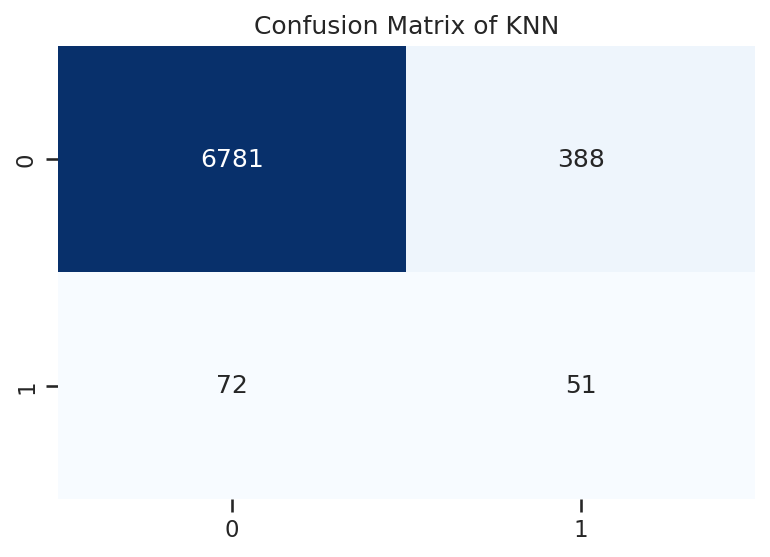

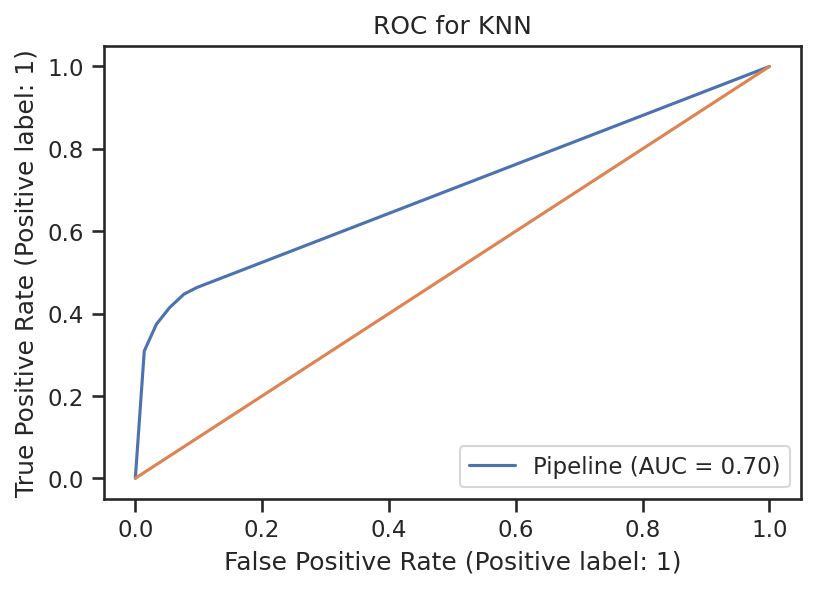

In [ ]:
params = {k[len('kneighborsclassifier__'):]:v for k,v in result_KNN.best_params_.items()}
KNN = make_pipeline(SMOTE(random_state = 42,sampling_strategy=0.33),
                     KNeighborsClassifier())
KNN.fit(X_train,y_train)
preds = KNN.predict(X_test)
print(classification_report(y_test,preds,digits = 4))

cm = confusion_matrix(y_test,preds)
sns.heatmap(cm, annot = True, fmt='d', cbar=False, cmap='Blues').set(title = "Confusion Matrix of KNN")

plot_roc_curve(KNN,X_test,y_test)
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100))
plt.title('ROC for KNN')
plt.show()

Text(0.5, 1.0, 'Cross Validation F1 Score of KNN with Different Parameters')

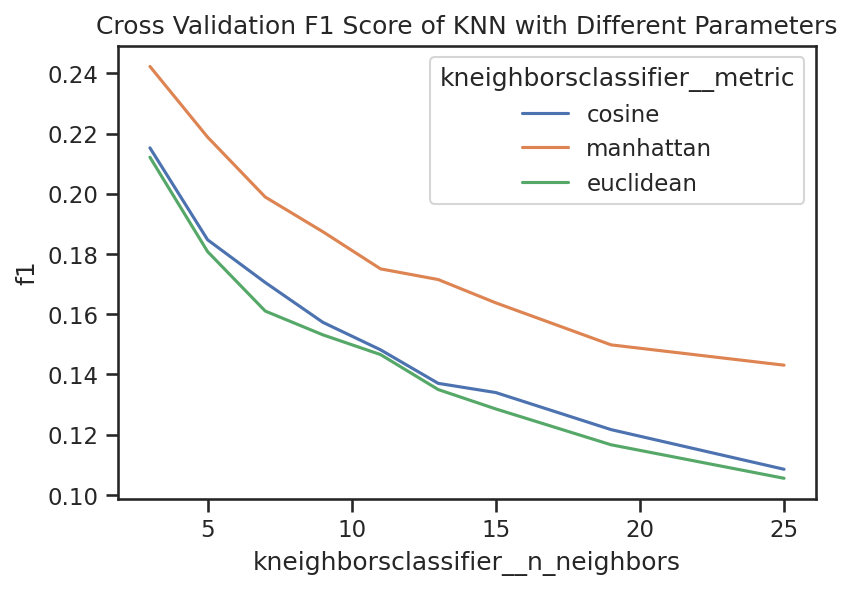

In [ ]:
data = pd.DataFrame(result_KNN.cv_results_['params'])
data['f1'] = result_KNN.cv_results_['mean_test_score']
sns.lineplot(x = 'kneighborsclassifier__n_neighbors', y = 'f1', hue = 'kneighborsclassifier__metric', data = data)
plt.title('Cross Validation F1 Score of KNN with Different Parameters')

Decision Tree

In [ ]:
pipeline_tree = make_pipeline(SMOTE(sampling_strategy = 0.33),
                              DecisionTreeClassifier(random_state = 42))

params = {'decisiontreeclassifier__max_depth' : [3,5,10,15,20,25,30,35,40,45],
          'decisiontreeclassifier__splitter' : ['random','best'],
          'decisiontreeclassifier__max_features' : ['auto','sqrt','log2']}

result_tree = GridSearchCV(pipeline_tree, param_grid=params, cv=5, scoring='f1',verbose = 3)
result_tree.fit(X_train, y_train)
params = {k[24:]:v for k,v in result_tree.best_params_.items()}

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__splitter=random;, score=0.073 total time=   0.1s
[CV 2/5] END decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__splitter=random;, score=0.057 total time=   0.1s
[CV 3/5] END decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__splitter=random;, score=0.080 total time=   0.1s
[CV 4/5] END decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__splitter=random;, score=0.094 total time=   0.1s
[CV 5/5] END decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=auto, decisiontreeclassifier__splitter=random;, score=0.000 total time=   0.1s
[CV 1/5] END decisiontreeclassifier__max_depth=3, decisiontreeclassifier__max_features=auto, decisiontreecla

              precision    recall  f1-score   support

           0     0.9876    0.9773    0.9824      7169
           1     0.1768    0.2846    0.2181       123

    accuracy                         0.9656      7292
   macro avg     0.5822    0.6309    0.6002      7292
weighted avg     0.9739    0.9656    0.9695      7292



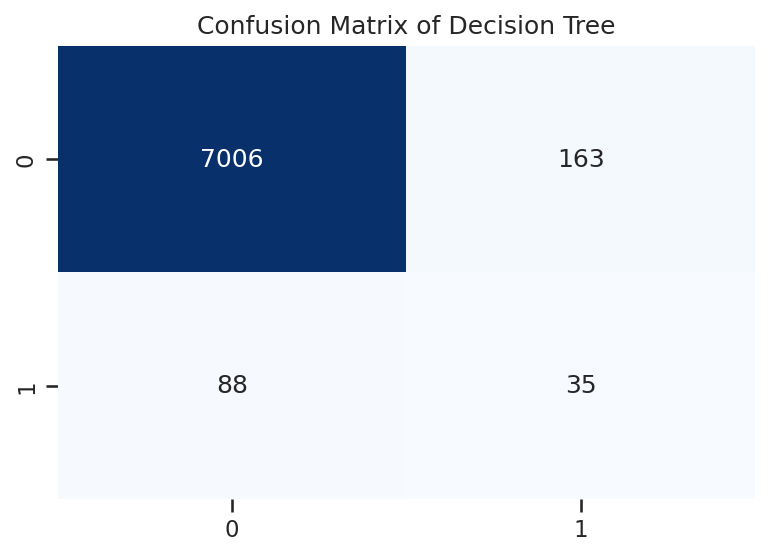

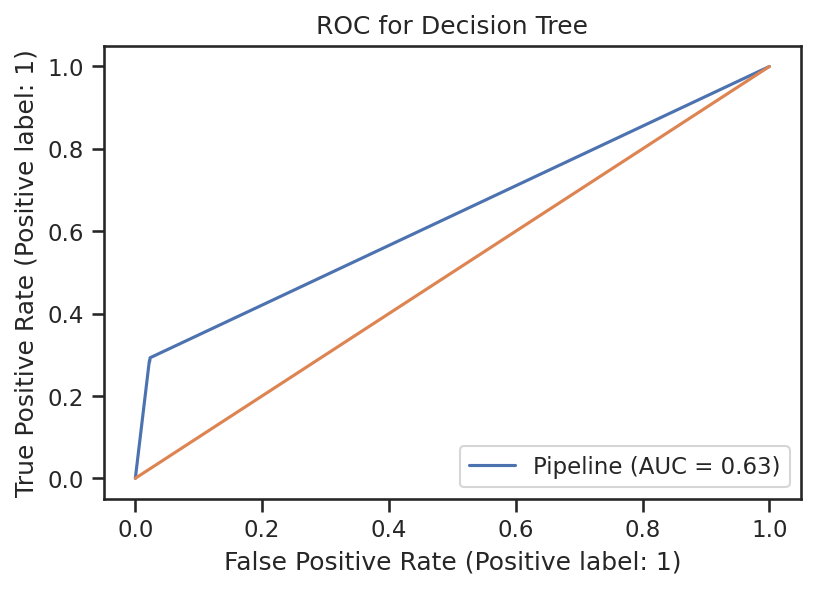

In [ ]:
params = {k[24:]:v for k,v in result_tree.best_params_.items()}
params['random_state'] = 42
Tree = make_pipeline(SMOTE(random_state = 43,sampling_strategy = 0.33),
                     DecisionTreeClassifier(**params))
Tree.fit(X_train,y_train)
preds = Tree.predict(X_test)
print(classification_report(y_test,preds,digits = 4))

cm = confusion_matrix(y_test,preds)
sns.heatmap(cm, annot = True, fmt='d', cbar=False, cmap='Blues').set(title = "Confusion Matrix of Decision Tree")

plot_roc_curve(Tree,X_test,y_test)
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100))
plt.title('ROC for Decision Tree')
plt.show()

Text(0.5, 1.0, 'Cross Validation F1 Score of Decision Tree with Different Parameters')

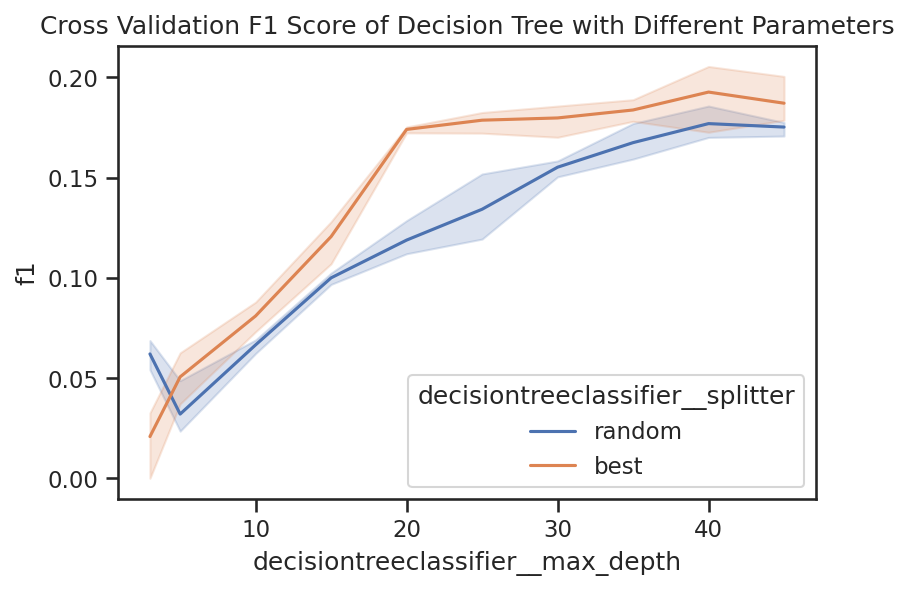

In [ ]:
data = pd.DataFrame(result_tree.cv_results_['params'])
data['f1'] = result_tree.cv_results_['mean_test_score']
sns.lineplot(x = 'decisiontreeclassifier__max_depth', y = 'f1', hue = 'decisiontreeclassifier__splitter', data = data)
plt.title('Cross Validation F1 Score of Decision Tree with Different Parameters')

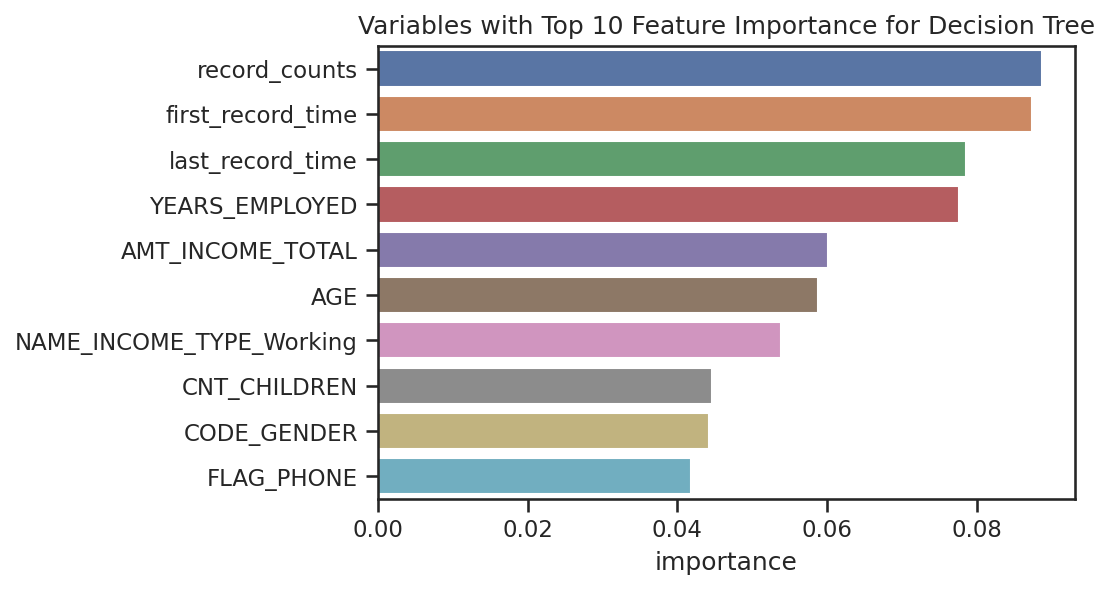

In [ ]:
data = pd.DataFrame({'predictors' : predictors,'importance': Tree[-1].feature_importances_}).sort_values(by = 'importance',ascending = False).iloc[:10,:]
ax = sns.barplot(y = 'predictors', x = 'importance', data = data)
ax.set_title('Variables with Top 10 Feature Importance for Decision Tree')
plt.ylabel(None)
plt.show()

RandomForest

In [ ]:
pipeline_forest = make_pipeline(SMOTE(random_state = 42, sampling_strategy = 0.33),
                               RandomForestClassifier(random_state = 42))

params = {'randomforestclassifier__n_estimators' : [50,100,150,200,250,500],
          'randomforestclassifier__max_depth' : [10,15,20,25,30,35,40,45],
           'randomforestclassifier__max_features' : ['auto','sqrt',None]}

result_forest = GridSearchCV(pipeline_forest, param_grid=params, cv=5, scoring='f1',verbose = 3)
result_forest.fit(X_train, y_train)
params = {k[24:]:v for k,v in result_forest.best_params_.items()}

Fitting 5 folds for each of 144 candidates, totalling 720 fits
[CV 1/5] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=50;, score=0.111 total time=   1.5s
[CV 2/5] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=50;, score=0.054 total time=   1.5s
[CV 3/5] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=50;, score=0.103 total time=   1.4s
[CV 4/5] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=50;, score=0.018 total time=   1.4s
[CV 5/5] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=auto, randomforestclassifier__n_estimators=50;, score=0.075 total time=   1.5s
[CV 1/5] END randomforestclassifier__max_depth=10, randomforestclassifier__max_features=auto, randomfo

              precision    recall  f1-score   support

           0     0.9870    0.9946    0.9908      7169
           1     0.4265    0.2358    0.3037       123

    accuracy                         0.9818      7292
   macro avg     0.7067    0.6152    0.6472      7292
weighted avg     0.9775    0.9818    0.9792      7292



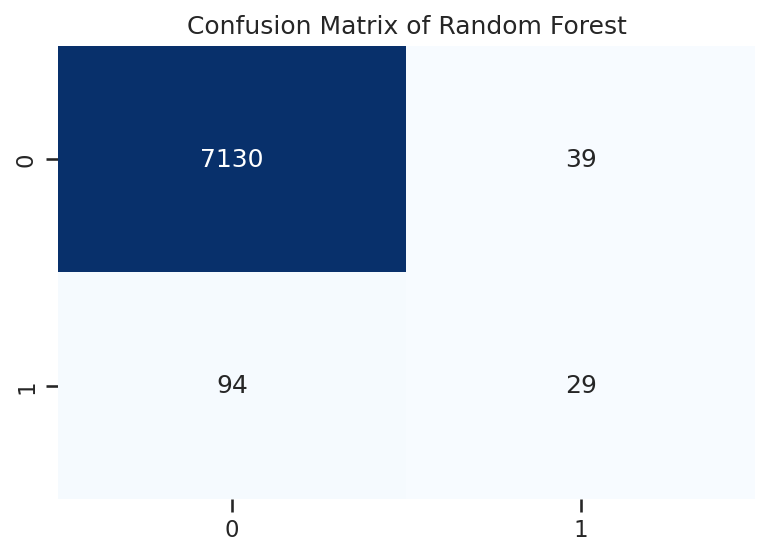

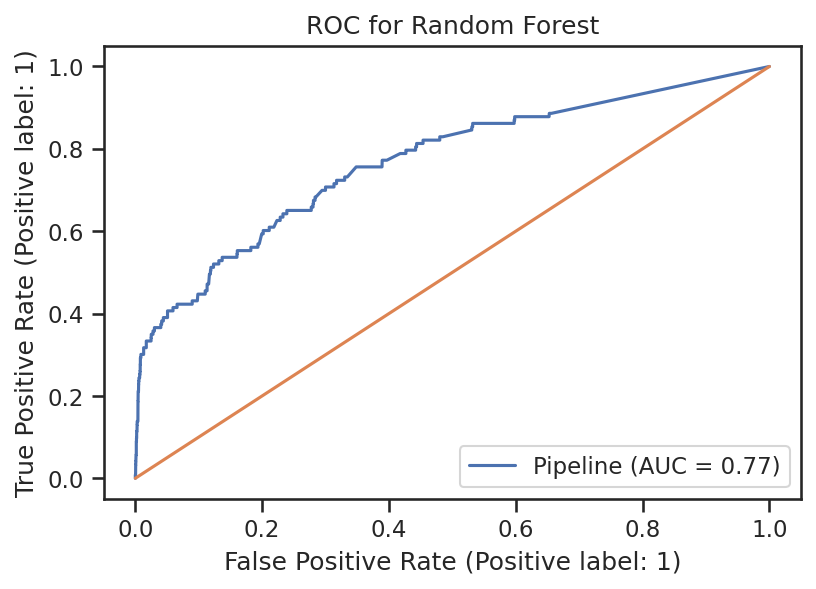

In [ ]:
params = {k[len('randomforestclassifier__'):]:v for k,v in result_forest.best_params_.items()}
params['random_state'] = 42
Forest = make_pipeline(SMOTE(random_state = 43,sampling_strategy = 0.33),
                       RandomForestClassifier(**params))
Forest.fit(X_train,y_train)
preds = Forest.predict(X_test)
print(classification_report(y_test,preds,digits = 4))

cm = confusion_matrix(y_test,preds)
sns.heatmap(cm, annot = True, fmt='d', cbar=False, cmap='Blues').set(title = "Confusion Matrix of Random Forest")

plot_roc_curve(Forest,X_test,y_test)
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100))
plt.title('ROC for Random Forest')
plt.show()

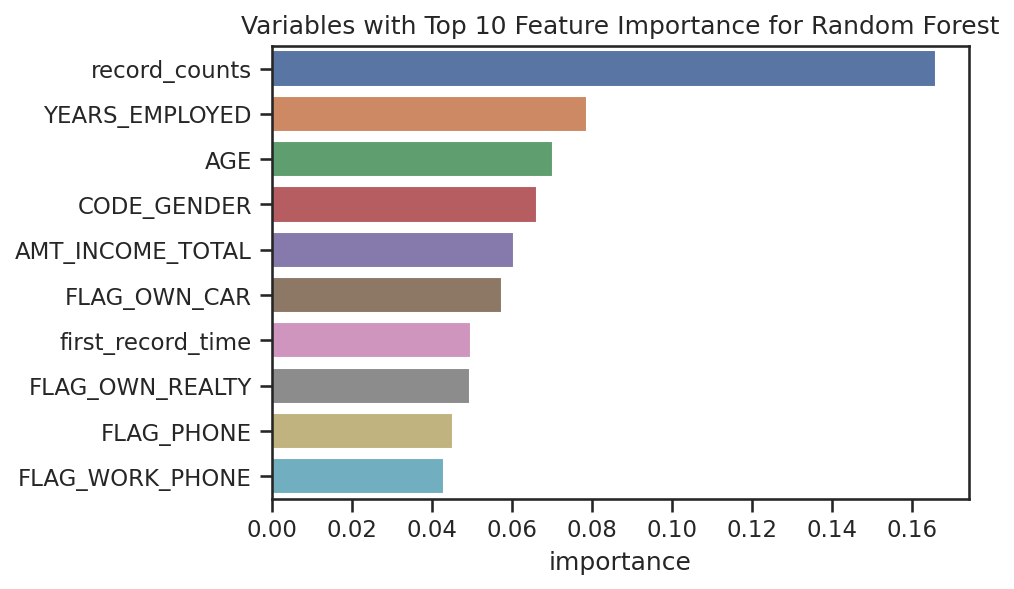

In [ ]:
data = pd.DataFrame({'predictors' : predictors,'importance': Forest[-1].feature_importances_}).sort_values(by = 'importance',ascending = False).iloc[:10,:]
ax = sns.barplot(y = 'predictors', x = 'importance', data = data)
ax.set_title('Variables with Top 10 Feature Importance for Random Forest')
plt.ylabel(None)
plt.show()

,randomforestclassifier__max_depth,randomforestclassifier__max_features,randomforestclassifier__n_estimators,f1
50,20,None,150,0.280793
49,20,None,100,0.279473
69,25,None,200,0.277967
87,30,None,200,0.277865
123,40,None,200,0.277435
...,...,...,...,...
2,10,auto,150,0.071180
10,10,sqrt,250,0.068286
4,10,auto,250,0.068286
11,10,sqrt,500,0.064910


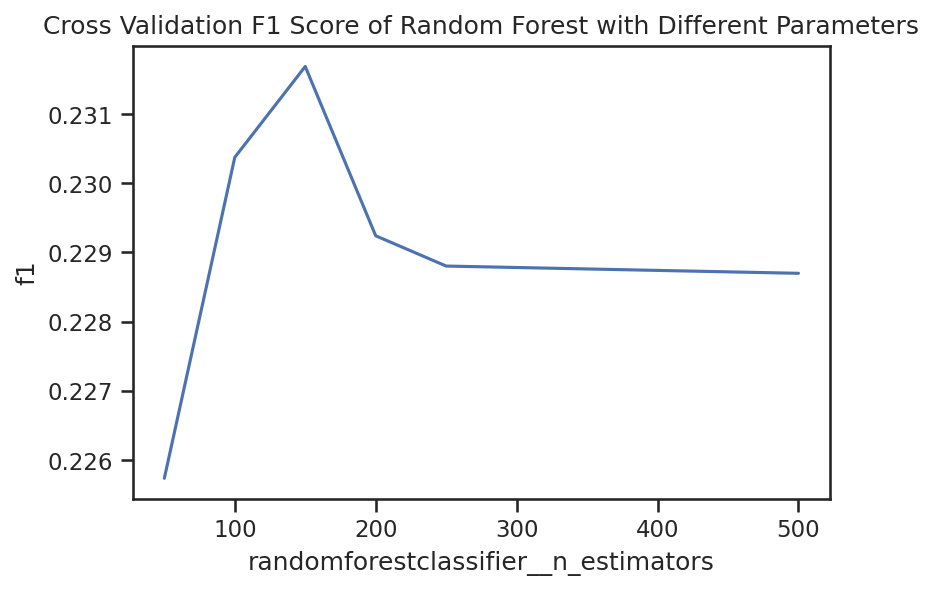

In [ ]:
data = pd.DataFrame(result_forest.cv_results_['params'])
data['f1'] = result_forest.cv_results_['mean_test_score']
sns.lineplot(x = 'randomforestclassifier__n_estimators', y = 'f1', data = data, ci = None)
# hue = 'randomforestclassifier__max_features'
plt.title('Cross Validation F1 Score of Random Forest with Different Parameters')

Boosting

In [ ]:
pipeline_boost = make_pipeline(SMOTE(random_state = 42, sampling_strategy = 0.33),
                               GradientBoostingClassifier(random_state = 42))

params = {'gradientboostingclassifier__n_estimators' : [50,100,150,200,250],
          'gradientboostingclassifier__max_depth' : [10,15,20,25,30,35,40,45],
          'gradientboostingclassifier__max_features' : ['auto','sqrt', 'log2']}

result_boost = GridSearchCV(pipeline_boost, param_grid=params, cv=5, scoring='f1',verbose = 3)
result_boost.fit(X_train, y_train)
params = {k[24:]:v for k,v in result_boost.best_params_.items()}

Fitting 5 folds for each of 120 candidates, totalling 600 fits
[CV 1/5] END gradientboostingclassifier__max_depth=10, gradientboostingclassifier__max_features=auto, gradientboostingclassifier__n_estimators=50;, score=0.190 total time=  12.4s
[CV 2/5] END gradientboostingclassifier__max_depth=10, gradientboostingclassifier__max_features=auto, gradientboostingclassifier__n_estimators=50;, score=0.133 total time=  12.2s
[CV 3/5] END gradientboostingclassifier__max_depth=10, gradientboostingclassifier__max_features=auto, gradientboostingclassifier__n_estimators=50;, score=0.226 total time=  12.3s
[CV 4/5] END gradientboostingclassifier__max_depth=10, gradientboostingclassifier__max_features=auto, gradientboostingclassifier__n_estimators=50;, score=0.220 total time=  12.3s
[CV 5/5] END gradientboostingclassifier__max_depth=10, gradientboostingclassifier__max_features=auto, gradientboostingclassifier__n_estimators=50;, score=0.168 total time=  12.3s
[CV 1/5] END gradientboostingclassifier__m

Text(0.5, 1.0, 'Cross Validation F1 Score of gradientboostingclassifier with Different Parameters')

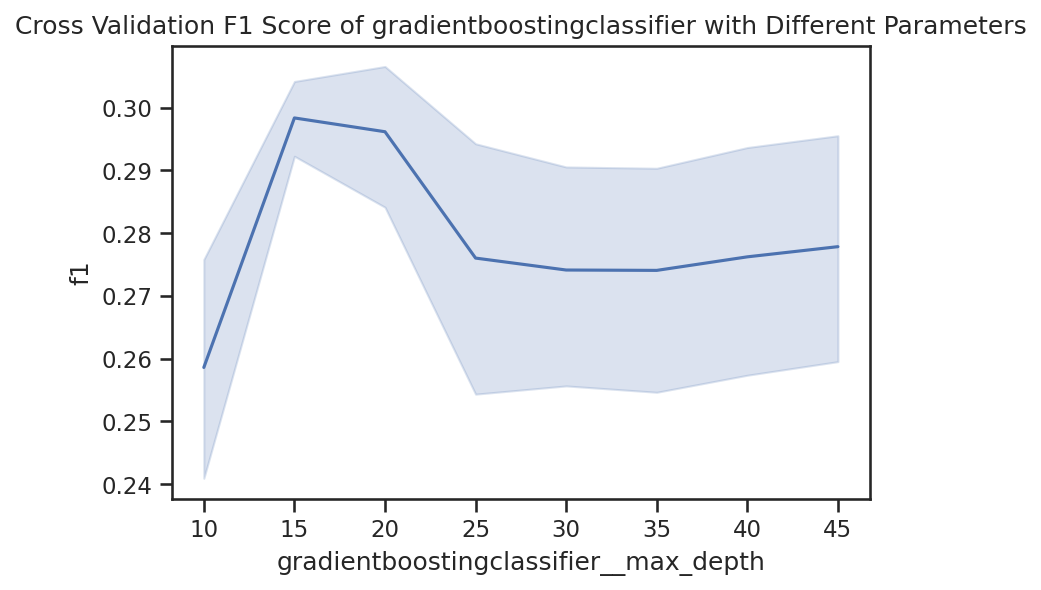

In [ ]:
data = pd.DataFrame(result_boost.cv_results_['params'])
data['f1'] = result_boost.cv_results_['mean_test_score']
sns.lineplot(x = 'gradientboostingclassifier__max_depth', y = 'f1', data = data)
# hue = 'randomforestclassifier__max_features'
plt.title('Cross Validation F1 Score of gradientboostingclassifier with Different Parameters')

              precision    recall  f1-score   support

           0     0.9855    0.9969    0.9912      7169
           1     0.4500    0.1463    0.2209       123

    accuracy                         0.9826      7292
   macro avg     0.7178    0.5716    0.6060      7292
weighted avg     0.9765    0.9826    0.9782      7292



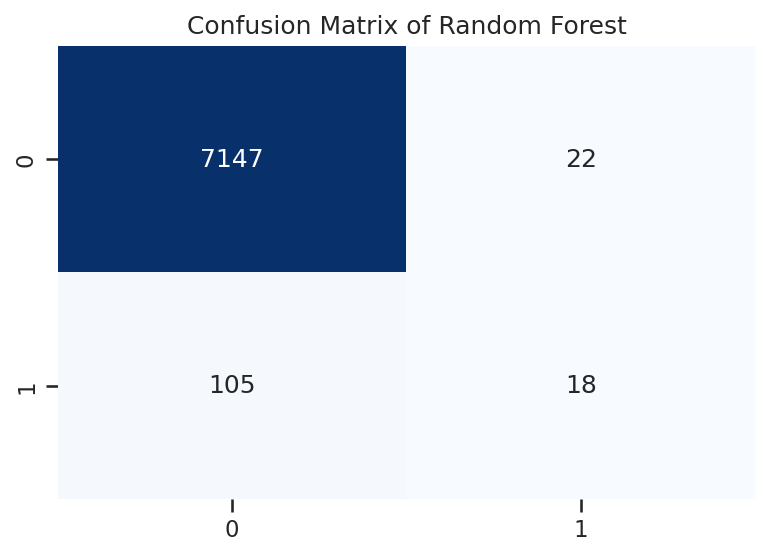

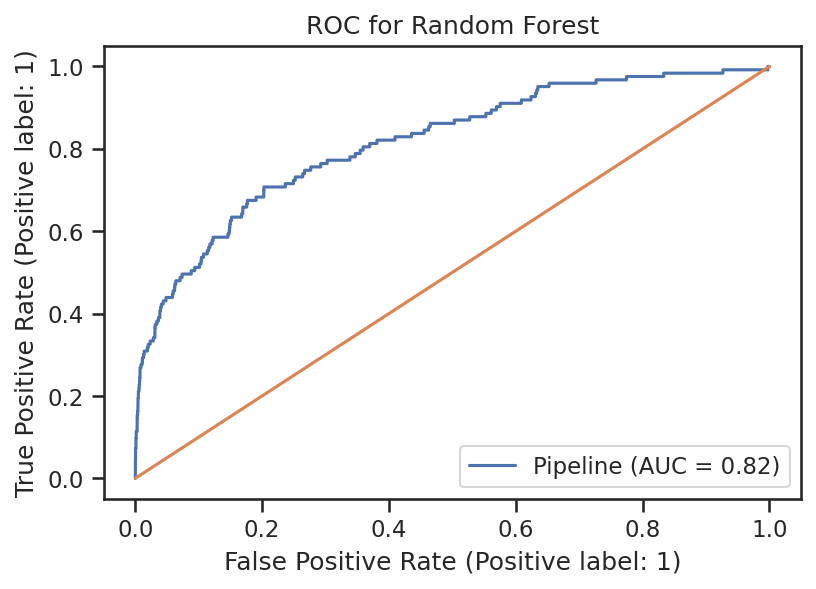

In [ ]:
#params = {k[len('GradientBoostingClassifier__'):]:v for k,v in result_boost.best_params_.items()}
#params['random_state'] = 42
#Boost = make_pipeline(SMOTE(random_state = 43,sampling_strategy = 0.33),
                       #GradientBoostingClassifier(**params))
#Boost.fit(X_train,y_train)
preds = result_boost.best_estimator_.predict(X_test)
print(classification_report(y_test,preds,digits = 4))

cm = confusion_matrix(y_test,preds)
sns.heatmap(cm, annot = True, fmt='d', cbar=False, cmap='Blues').set(title = "Confusion Matrix of Random Forest")

plot_roc_curve(result_boost.best_estimator_,X_test,y_test)
plt.plot(np.linspace(0,1,100),np.linspace(0,1,100))
plt.title('ROC for Random Forest')
plt.show()

Multilayer Perceptron

In [ ]:
Sampler = SMOTE()
X_balanced, y_balanced = Sampler.fit_resample(X_train,y_train)

train_x = np.asarray(X_balanced).astype("float32")
test_x = np.asarray(X_test).astype("float32")
train_y = np.asarray(y_balanced).astype("float32")
test_y = np.asarray(y_test).astype("float32")

model = keras.Sequential(
    [
        layers.Dense(64, activation="relu", name="layer1"),
        layers.Dense(128, activation="relu", name="layer2"),
        layers.Dense(1, name="layer3", activation  = 'sigmoid'),
    ]
)

model.compile(optimizer = keras.optimizers.Adam(learning_rate= 1e-3),loss = 'binary_crossentropy', metrics = ['accuracy'])
model.fit(x = train_x,y = train_y,epochs = 100,shuffle = True, batch_size = 128,validation_data = [test_x,test_y])

Epoch 1/100
448/448 [==============================] - 2s 3ms/step - loss: 0.4238 - accuracy: 0.8037 - val_loss: 0.3869 - val_accuracy: 0.8079
Epoch 2/100
448/448 [==============================] - 1s 3ms/step - loss: 0.2324 - accuracy: 0.9112 - val_loss: 0.2106 - val_accuracy: 0.9157
Epoch 3/100
448/448 [==============================] - 1s 3ms/step - loss: 0.1607 - accuracy: 0.9427 - val_loss: 0.2072 - val_accuracy: 0.9231
Epoch 4/100
448/448 [==============================] - 1s 2ms/step - loss: 0.1239 - accuracy: 0.9575 - val_loss: 0.2158 - val_accuracy: 0.9222
Epoch 5/100
448/448 [==============================] - 1s 2ms/step - loss: 0.1022 - accuracy: 0.9661 - val_loss: 0.1624 - val_accuracy: 0.9572
Epoch 6/100
448/448 [==============================] - 1s 3ms/step - loss: 0.0882 - accuracy: 0.9717 - val_loss: 0.1940 - val_accuracy: 0.9431
Epoch 7/100
448/448 [==============================] - 1s 3ms/step - loss: 0.0790 - accuracy: 0.9738 - val_loss: 0.1996 - val_accuracy: 0.9431

In [ ]:
data = pd.DataFrame(model.predict(test_x),columns = ['proba'])
data['target'] = data['proba'].apply(lambda x: 1 if x > 0.5 else 0 )
print(classification_report(y_test,data['target'], digits = 4))

228/228 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0     0.9882    0.9773    0.9827      7169
           1     0.1931    0.3171    0.2400       123

    accuracy                         0.9661      7292
   macro avg     0.5906    0.6472    0.6113      7292
weighted avg     0.9747    0.9661    0.9702      7292



# Nested CV for all models

In [ ]:
cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
# define the model
Logistic = make_pipeline(SMOTE(sampling_strategy = 0.33,random_state = 42),
                               LogisticRegression(random_state = 42,penalty = 'l2'))
params = {'logisticregression__C':[0.9,0.5,0.1,0.01,0.001]}
# define search space
search = GridSearchCV(Logistic, params, scoring='f1', n_jobs=1, cv=cv_inner, refit=True,verbose = 3)
# configure the cross-validation procedure
cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)
# execute the nested cross-validation
scores = cross_val_score(search, X, y, scoring='f1', cv=cv_outer)
# report performance
print('f1: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

In [ ]:
cv_inner = KFold(n_splits=5, shuffle=True)
# define the model
KNN = make_pipeline(SMOTE(sampling_strategy = 0.33),
                    KNeighborsClassifier(metric = 'manhattan'))

params = {'kneighborsclassifier__n_neighbors':[3,5,7,9,11]}
# define search space
search = GridSearchCV(KNN, params, scoring='f1', n_jobs=1, cv=cv_inner, refit=True,verbose = 3)
# configure the cross-validation procedure
cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)
# execute the nested cross-validation
scores = cross_val_score(search, X, y, scoring='f1', cv=cv_outer)
# report performance
print('f1: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

In [ ]:
cv_inner = KFold(n_splits=5, shuffle=True, random_state=42)
# define the model
tree = make_pipeline(SMOTE(sampling_strategy = 0.33),
                              DecisionTreeClassifier(random_state = 42))

params = {'decisiontreeclassifier__max_depth' : [25,30,35,40,45]}

# define search space
search = GridSearchCV(tree, params, scoring='f1', n_jobs=1, cv=cv_inner, refit=True,verbose = 3)
# configure the cross-validation procedure
cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)
# execute the nested cross-validation
scores = cross_val_score(search, X, y, scoring='f1', cv=cv_outer)
# report performance
print('f1: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

In [ ]:
cv_inner = KFold(n_splits=5, shuffle=True, random_state=42)
# define the model
forest = make_pipeline(SMOTE(random_state = 42, sampling_strategy = 0.33),
                       RandomForestClassifier(random_state = 42, n_estimators = 150, max_features = 'auto'))

params = {'randomforestclassifier__max_depth' : [25,30,35,40,45]}

# define search space
search = GridSearchCV(forest, params, scoring='f1', n_jobs=1, cv=cv_inner, refit=True,verbose = 3)
# configure the cross-validation procedure
cv_outer = KFold(n_splits=5, shuffle=True, random_state=1)
# execute the nested cross-validation
scores = cross_val_score(search, X, y, scoring='f1', cv=cv_outer)
# report performance
print('f1: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

In [ ]:
credit.shape

(1048575, 3)